# Overview
The task is to identify sleep patterns given samples of accelerometer data. 

In [1]:
# Render our plots inline
%matplotlib inline

import numpy as np
import h5py
import pandas as pd
import datetime 
import matplotlib.pyplot as plt
from pandas import HDFStore,DataFrame
import itertools


In [2]:
def load_data(filename):
    path = 'D:/path/'+ filename
    hf = h5py.File(path, 'r')

    reread = pd.read_hdf(path)
    data = reread#.head(10000)
    hf.close()
    return data

def load_csv(filename):
    data = pd.read_csv('D:/path/'+ filename)
    
    return data

def load_targets(subject_number):
    filename = 'D:/path/ID'+str(subject_number)+'/PSG'+ str(subject_number) +'_targets.h5'
    hf = h5py.File(filename, 'r')

    reread = pd.read_hdf(filename)
    targets = reread#.head(10000)
    hf.close()
    return targets

def load_features(subject_number):
    filename = 'D:/path/ID'+str(subject_number)+'/PSG'+ str(subject_number) +'_features.h5'
    hf = h5py.File(filename, 'r')

    reread = pd.read_hdf(filename)
    features = reread#.head(10000)
    hf.close()
    return features

In [3]:
def combine_data(subject_ids):
    
    data = []
    y = []
    
    
    for i in range(len(subject_ids)):
        
        features = load_features(subject_ids[i])
        targets = load_targets(subject_ids[i])
        
        data.append(features)
        y.append(targets)
    
    result_X = pd.concat(data)
    result_X = result_X.reset_index()
    result_X = result_X.drop(['index'], axis = 1)
    
    result_y = pd.concat(y)
    result_y = result_y.reset_index()
    result_y = result_y.drop(['index'], axis = 1)
    
    return result_X.values, result_y.values.ravel()

In [4]:
# subject_ids = [1,6,14,15,18,19,20,23,24,25,27,28,29,30,31,32,35,37,39]

unlabelled_ids =[6, 15, 19, 20, 24, 25, 27, 28, 30, 31, 32, 35]

train_ids =[1, 23, 29, 37, 39]

test_ids = [14, 18]

X_train, y_train = combine_data(train_ids)
X_test, y_test = combine_data(test_ids)
X_unl, y_unl = combine_data(unlabelled_ids)
extra_unl = load_data('Unlabelled_data.h5').values

In [5]:
unlabelled = np.concatenate([X_unl.copy(), extra_unl.copy()])

# Model building and evaluation

In [8]:
import sklearn.metrics as met
import seaborn as sn
import math
    
#helper function to quickly build different models
def model_build(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def plot_confusion_matrix(array):
    array = array
    x_labels = ['sleep', 'wake']
    y_labels = ['sleep', 'wake']
    df_cm = pd.DataFrame(array, y_labels,x_labels)
    plt.figure(figsize = (4,4))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", fmt='g')# font size
    plt.show()

# helper function to handle evaluation
def model_eval(model, X_test, y_test):
    pred = model.predict(X_test)
    print('Accuracy:\n-----------------------------')
    print(met.accuracy_score(y_test, pred))
    print('\nConfusion Matrix:\n-----------------------------')
    conf = met.confusion_matrix(y_test, pred)
    plot_confusion_matrix(conf)
    print('\nClassification Report:\n-----------------------------')
    print(met.classification_report(y_test, pred, digits= 5))
    
    TP = conf.tolist()[0][0]
    FN = conf.tolist()[0][1]
    FP = conf.tolist()[1][0]
    TN = conf.tolist()[1][1]
    sen = TP/(TP+FN)
    spe = TN/(TN+FP)
    gmean= math.sqrt(sen*spe)
    
    print('TP, FN, FP, TN: '+ str(TN)+', '+ str(FP)+', '+str(FN)+', '+str(TP))
    print('Sensitivity:' + str(sen))
    print('Specificity:' + str(spe))
    print('G-mean:'+ str(gmean))

In [9]:
from sklearn.metrics import accuracy_score

# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Extreme Gradient Boosting
from xgboost import XGBClassifier
#import xgboost as xgb
from sklearn.svm import SVC  

from sklearn.cross_validation import train_test_split, cross_val_score

#The co-Training singleview method.
def CoSV(X_train, y_train, unlabelled_data, X_test, y_test):
    
    print('Unlabelled data left: ' +str(len(unlabelled_data)))
    
    #Set initial value for k
    k = 0.001

    #While instances left in unlabelled update labelled and unlabelled data sets.
    while len(unlabelled_data)>0:
        X_train, y_train, unlabelled_data, k = add_unlabelled(X_train, y_train, unlabelled_data, k)
    
    return X_train, y_train
    

#This method removed the instances from the unlabelled data set with a prediction confidence from the most accurate classifier
#that is above a set threshold and adds them to the labelled data set. 
def add_unlabelled(X_train, y_train, unlabelled_data, k):
    
    #Number of instances left in unlabelled
    length = len(unlabelled_data)
    
    #Get the current most accurate classifier
    model = get_most_accurate(X_train, y_train)
    
    #Train specified classifier
    if model == 'rf':
        classifier = model_build(RandomForestClassifier(n_estimators=20), X_train, y_train)
    else:
        classifier = model_build(XGBClassifier(n_estimators=150), X_train, y_train)
    
    #Get lists containing instances with most confident predictions and updated unlabelled data set
    highest_conf_X, highest_conf_y, unlabelled_data = get_most_confident(classifier, unlabelled_data, k)
    
    #Combine labelled data with lists
    X_train = np.concatenate([X_train, highest_conf_X])
    y_train = np.concatenate([y_train, highest_conf_y])
    
    #Update k value
    if (length - len(unlabelled_data)) < 1000 and k<0.64:
        k = k*2
    
    print('Unlabelled data left: '+str(len(unlabelled_data)))
        
    return X_train, y_train, unlabelled_data, k


#This method returns the instances in unlabelled with predictions over a set threshold and removed them from the unlabelled data
#set. The updated unlabelled data set is also returned.
def get_most_confident(classifier, unlabelled_data, k):
    
    #Set threshold
    confidences = classifier.predict_proba(unlabelled_data)
    highest_value = np.amax(confidences)
    length = len(unlabelled_data)
    threshold = highest_value - k

    #Create empty lists for instances with highest prediction confidences
    highest_conf_X = []
    highest_conf_y = []

    #Instances/rows left in unlabelled data
    instances = np.copy(unlabelled_data)
    
    index = 0
    for i in range(len(instances)):
        #Gets the prediction confidences for the instance
        instance = instances[i]
        conf = confidences[i]

        sleep_conf = conf[0]
        wake_conf = conf[1]
        
        #Checks which prediction is the most confident and if it is above threshold add the instance to labelled
        # and removed from unlabelled
        if sleep_conf > wake_conf and sleep_conf>threshold:
            highest_conf_y.append(1)
            highest_conf_X.append(instance)
            unlabelled_data = np.delete(unlabelled_data, index, 0)
        elif wake_conf >= sleep_conf and wake_conf>threshold:
            highest_conf_y.append(2)
            highest_conf_X.append(instance)
            unlabelled_data = np.delete(unlabelled_data, index, 0)
        else:
            #If no instance is added to labelled then the index is increased
            index = index + 1
    
    return highest_conf_X, highest_conf_y, unlabelled_data


# returns the most acurate classifier between random forest and xgb based on the current labelled data set
def get_most_accurate(labelled_data_X, labelled_data_y):

    #Splits the labelled data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(labelled_data_X, labelled_data_y, test_size = .25, random_state=1)
    
    #Trains RF classifier and gets accuracy score
    rf = model_build(RandomForestClassifier(n_estimators=20), X_train, y_train.ravel())
    rf_pred = rf.predict(X_test)
    rf_acc = accuracy_score(y_test.ravel(), rf_pred)
    
    #Trains XGB classifier and gets accuracy score
    xgbc = model_build(XGBClassifier(n_estimators=150), X_train, y_train.ravel())
    xgb_pred = xgbc.predict(X_test)
    xgb_acc = accuracy_score(y_test.ravel(), xgb_pred)
    
    #Returns the classifier with the highest accuracy score
    if rf_acc > xgb_acc:
        return 'rf'
    else:
        return 'xgb'
                            

C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Training and validation

In [10]:
#All features
X_train_cosv, y_train_cosv = CoSV(X_train, y_train.ravel(), unlabelled, X_test, y_test)

Unlabelled data left: 53221


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unlabelled data left: 41020


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unlabelled data left: 27687


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unlabelled data left: 18681


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unlabelled data left: 13257


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unlabelled data left: 9793


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unlabelled data left: 7845


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unlabelled data left: 6451


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unlabelled data left: 5678


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unlabelled data left: 5148


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unlabelled data left: 4779


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unlabelled data left: 4463


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unlabelled data left: 4200


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unlabelled data left: 4037


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unlabelled data left: 3490


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unlabelled data left: 3012


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unlabelled data left: 2116


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unlabelled data left: 0


In [17]:
#Save data

X = pd.DataFrame(X_train_cosv)
y = pd.DataFrame(y_train_cosv)
#X.to_hdf('X_train_cosv_0.h5', key = 'xtraincosv')
#y.to_hdf('y_train_cosv_0.h5', key = 'ytraincosv')

Accuracy:
-----------------------------
0.830423940149626

Confusion Matrix:
-----------------------------


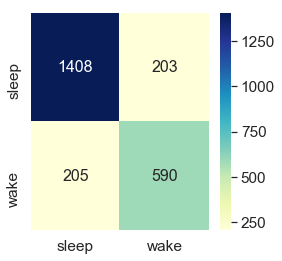


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.87291   0.87399   0.87345      1611
          2    0.74401   0.74214   0.74307       795

avg / total    0.83032   0.83042   0.83037      2406

TP, FN, FP, TN: 590, 205, 203, 1408
Sensitivity:0.8739913097454997
Specificity:0.7421383647798742
G-mean:0.8053710209874363


In [13]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier

dtc = model_build(DecisionTreeClassifier(), X_train, y_train)
model_eval(dtc, X_test,y_test)

Accuracy:
-----------------------------
0.9123025768911056

Confusion Matrix:
-----------------------------


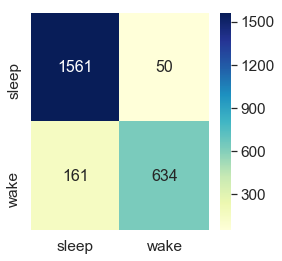


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.90650   0.96896   0.93669      1611
          2    0.92690   0.79748   0.85734       795

avg / total    0.91324   0.91230   0.91047      2406

TP, FN, FP, TN: 634, 161, 50, 1561
Sensitivity:0.9689633767846059
Specificity:0.7974842767295598
G-mean:0.8790523634644886


In [14]:
#Random Forest

rfc = model_build(RandomForestClassifier(n_estimators=20), X_train, y_train)
model_eval(rfc, X_test, y_test)

Accuracy:
-----------------------------
0.9197838736492103

Confusion Matrix:
-----------------------------


C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


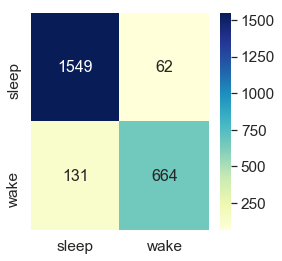


Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1    0.92202   0.96151   0.94136      1611
          2    0.91460   0.83522   0.87311       795

avg / total    0.91957   0.91978   0.91881      2406

TP, FN, FP, TN: 664, 131, 62, 1549
Sensitivity:0.9615145872129113
Specificity:0.8352201257861636
G-mean:0.8961452641604478


In [15]:
#XGBoost

xgbc = model_build(XGBClassifier(n_estimators=150), X_train, y_train)
model_eval(xgbc, X_test, y_test)

C:\Users\ailee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


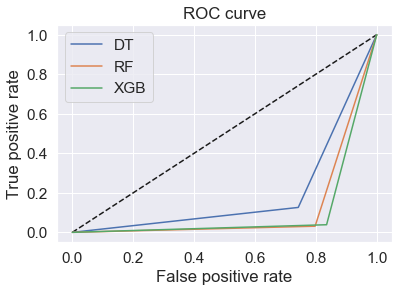

In [16]:
#ROC -curve

pred_dt = dtc.predict(X_test)
fpr_dt, tpr_dt, thresholds_dt = met.roc_curve(y_test, pred_dt, pos_label=1)

pred_rf = rfc.predict(X_test)
fpr_rf, tpr_rf, thresholds_rf = met.roc_curve(y_test, pred_rf, pos_label=1)

pred_xgb = xgbc.predict(X_test)
fpr_xgb, tpr_xgb, thresholds_dt = met.roc_curve(y_test, pred_xgb, pos_label=1)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dt, tpr_dt, label='DT')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_xgb, tpr_xgb, label='XGB')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()